This notebook focuses on determining the optimal threshold for the Matthews Correlation Coefficient (MCC) metric.

The NodePropertyPrediction class generates a single float tensor of shape (num_residue, ) as its prediction output. Unlike the Area Under the Receiver Operating Characteristic (AUROC) which doesn't need a prediction threshold to calculate the metric from the prediction, the MCC does. This necessitates establishing a threshold that enhances the MCC metric.

It's technically feasible to set this threshold after the model has been trained. However, this approach is problematic for a key reason. In machine learning, it's considered "unfair" or incorrect to use the labels from the test set to adjust the model, including setting the prediction threshold. This is because it can cause overfitting and provide an overly optimistic estimate of the model's performance. This is why we aim to make predictions without prior knowledge of the labels in the training set.

To address this, we set the threshold before the model training begins. We do this by hypothetically training the model on the training set and determining the threshold that maximizes the MCC metric on the validation set.

After finding the appropriate threshold, we then apply it in a separate evaluation process on the test set. Specifically, we use the model parameters learned from the training process, along with the threshold determined from the validation set, to make predictions and calculate the MCC on the test set. This is a separate process because it's done after the model has been trained and the threshold has been set. By doing this, we can ensure a fair and unbiased assessment of the model's performance.

Split num:  [346, 42, 41]
train samples: 346, valid samples: 42, test samples: 41
Finished trial 1
Split num:  [346, 42, 41]
train samples: 346, valid samples: 42, test samples: 41
Finished trial 2
Split num:  [346, 42, 41]
train samples: 346, valid samples: 42, test samples: 41
Finished trial 3
Split num:  [346, 42, 41]
train samples: 346, valid samples: 42, test samples: 41
Finished trial 4
Split num:  [346, 42, 41]
train samples: 346, valid samples: 42, test samples: 41
Finished trial 5
Split num:  [346, 42, 41]
train samples: 346, valid samples: 42, test samples: 41
Finished trial 6
Split num:  [346, 42, 41]
train samples: 346, valid samples: 42, test samples: 41
Finished trial 7
Split num:  [346, 42, 41]
train samples: 346, valid samples: 42, test samples: 41
Finished trial 8
Split num:  [346, 42, 41]
train samples: 346, valid samples: 42, test samples: 41
Finished trial 9
Split num:  [346, 42, 41]
train samples: 346, valid samples: 42, test samples: 41
Finished trial 10


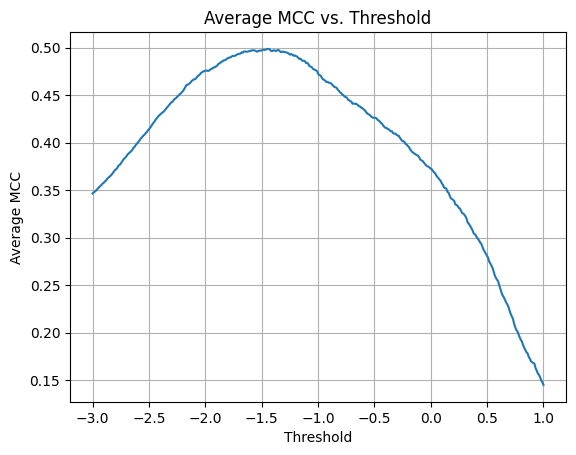

In [4]:
%matplotlib inline

from lib.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchdrug import utils, data
from lib.disable_logger import DisableLogger

TRIALS = 10

thresholds = np.linspace(-3, 1, num=400)
mcc_values = [0 for i in range(len(thresholds))]


for _ in range(TRIALS):
    pipeline = Pipeline(model='bert', dataset='atpbind', gpus=[2],
                        model_kwargs={
                            'freeze_bert': False,
                            'freeze_layer_count': 29
                        })
    with DisableLogger():
        pipeline.train(num_epoch=2)
    
    preds = []
    targets = []

    dataloader = data.DataLoader(pipeline.test_set, batch_size=1, shuffle=False)

    with torch.no_grad():
        for batch in dataloader:
            batch = utils.cuda(batch, device=torch.device('cuda:2'))
            pred, target = pipeline.task.predict_and_target(batch)
            preds.append(pred)
            targets.append(target)

    pred = utils.cat(preds)
    target = utils.cat(targets)
    
    for i, threshold in enumerate(thresholds):
        mcc = pipeline.task.evaluate(
            pred, target, threshold
        )['mcc']
        mcc_values[i] = mcc_values[i] + mcc
    
    print(f'Finished trial {_ + 1}')

mcc_values = [mcc / TRIALS for mcc in mcc_values]

plt.plot(thresholds, mcc_values)
    
plt.xlabel('Threshold')
plt.ylabel('Average MCC')
plt.title('Average MCC vs. Threshold')
plt.grid(True)
plt.show()
    